<a href="https://colab.research.google.com/github/jhejna/rlworkshop/blob/main/MF_RL_Workshop_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup
Run the following cells to test the installation and make sure everything is working.

In [ ]:
# Check if we have GPU
import torch
if torch.cuda.is_available():
    print("GPU working!")
else:
    print("WARNING: The Colab runtime does not have GPU enabled.")
    print("         You should be able to train the models on CPU, but if you")
    print("         want GPU, enable it in Runtime > Change Runtime Type")

         You should be able to train the models on CPU, but if you
         want GPU, enable it in Runtime > Change Runtime Type


In [ ]:
%%bash
# install required system dependencies
apt-get install -y xvfb x11-utils
# install required python dependencies (might need to install additional gym extras depending)
pip install gym pyvirtualdisplay

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,977 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.7 [783 kB]
Fetched 993 kB in 1s (1,366 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
S

In [ ]:
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False, size=(640, 480))
_ = _display.start()

In [ ]:
# This should produce a non-blank output.
!echo $DISPLAY

:0


Episodes: 4


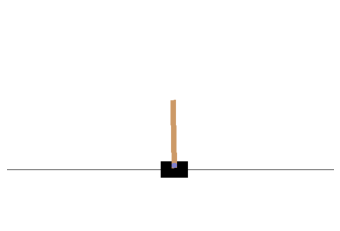

In [ ]:
# Test rendering a gym environment
import gym
import matplotlib.pyplot as plt
from IPython import display

env = gym.make('CartPole-v1')
num_ep = 0
obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for _ in range(100):
    ac = env.action_space.sample()
    obs, reward, done, info = env.step(ac)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done:
        obs = env.reset()
        num_ep += 1
env.close()
del env
del img
print("Episodes:", num_ep)

# 1. REINFORCE
Here we'll implement the basic policy gradient algorithm REINFORCE in pytorch for the above cart-pole environment.

In [ ]:
# Import the required modules
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import gym

## a) Policy Network
First we need to implement the policy network. The policy network takes in observations and outputs actions that should be taken. Our policy will be implemented in the form of an MLP

Our policy class must do the following:
1. Take in an observation from the environment, and return the action to take.
2. Given an observation and action, compute the log probability of taking that action under the current policy. This is used for computing the REINFORCE loss.

There are a few considerations to keep in mind:

**Discrete Actions**: The cartpole environment has an action space of size 2, indicating if the cart should move to the left or right. This means we will need to output a categorical distribution. Think about the best way to implement this. (Hint: classification)

**Exploration**: Remember that for RL to work, we need to explore. Make sure you have some randomness in your action selection.

Fill out the following class to complete the policy network.

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, layers=[128, 128], act=nn.ReLU):
        super().__init__()
        last_dim = in_dim
        model = []
        for layer in layers:
            model.append(nn.Linear(last_dim, layer))
            last_dim = layer
            model.append(act())
        model.append(nn.Linear(last_dim, out_dim))
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Policy(nn.Module):
    def __init__(self, action_space, observation_space, layers=[64, 64], act=nn.ReLU):
        super().__init__()
        self.action_space = action_space
        self.observation_space = observation_space
        self.net = MLP(observation_space.shape[0], action_space.n, layers=layers, act=act)

    def forward(self, obs):
        logits = self.net(obs)
        action_distribution = F.softmax(logits)
        return action_distribution

    def get_action(self, obs, deterministic=False):
        with torch.no_grad():
            obs = torch.from_numpy(obs).float().unsqueeze(0)
            action_distribution = self(obs)[0].cpu().numpy()
        if deterministic:
            return np.argmax(action_distribution)
        else:
            # print(self.action_space.n, action_distribution, np.random.choice(self.action_space.n, p=action_distribution))
            return np.random.choice(self.action_space.n, p=action_distribution)
        
    def log_prob(self, action, obs):
        assert len(obs.shape) == 2, "Observation must be batched for log_prob"
        action_distribution = self(obs)
        probs = torch.gather(action_distribution, -1, action)
        return torch.log(probs)


## b) Training Loop
Next, we need to actually train the policy network. This is done in two phases:
1. Data Collection: execute the policy in the enviornment and explore, collecting experience. For this you may need to refer to the gym environment interface. See how we did it in the setup or check out the documentation here: https://gym.openai.com/docs/
2. Update the policy: use the collected experience to update the policy using the computed policy gradient.

We have provided some skeleton code for the training loop. 

In [ ]:
# Hyper-parameters
iterations = 64
epochs_per_iter = 4
timesteps_per_iter = 2048
batch_size = 512
learning_rate = 1e-4
gamma = 0.99
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v1')
obs = env.reset()

policy = Policy(env.action_space, env.observation_space, layers=[64, 64], act=nn.Tanh)
optim = torch.optim.Adam(policy.parameters(), lr=learning_rate)

for iter in range(iterations):
    # First, collect data
    
    # Setup the data collection buffers
    observations = np.zeros((timesteps_per_iter, *env.observation_space.shape), dtype=np.float)
    actions = np.zeros((timesteps_per_iter, 1), np.float)
    rewards = np.zeros(timesteps_per_iter, np.float)
    dones = np.zeros(timesteps_per_iter, dtype=np.bool)
    
    # Collect the data
    for i in range(timesteps_per_iter):
        action = policy.get_action(obs, deterministic=False)
        # Record the observations and action
        observations[i], actions[i] = obs, action
        obs, reward, done, _ = env.step(action)
        # Record the consequences
        rewards[i], dones[i] = reward, done
        if done:
            obs = env.reset()
    print("Average Reward:", np.sum(rewards) / np.sum(dones))

    # Compute the reward to go
    reward_to_go = np.zeros(timesteps_per_iter)
    reward_to_go[-1] = rewards[-1] # init the reward to go array

    for i in reversed(range(timesteps_per_iter - 1)):
        reward_to_go[i] = rewards[i] + gamma * reward_to_go[i+1] * (1 - dones[i+1])
    
    # Compute the advantage
    advantages = reward_to_go - np.mean(reward_to_go)

    # Convert everything to pytorch objects now for efficiency
    observations = torch.from_numpy(observations).float()
    actions = torch.from_numpy(actions).long()
    advantages = torch.from_numpy(advantages).float()
    
    # Update the policy
    for epoch in range(epochs_per_iter):
        indices = np.random.permutation(timesteps_per_iter)
        # Note this is a bit sloppy as we don't necesarily hit all data points if batch does not evenly divide timesteps 
        for i in range(timesteps_per_iter // batch_size): 
            batch_indices = indices[i*batch_size:(i+1)*batch_size]
            batch_obs, batch_actions, batch_advantages = observations[batch_indices], actions[batch_indices], advantages[batch_indices]
            # Now update the policy
            optim.zero_grad()            
            log_probs = policy.log_prob(batch_actions, batch_obs).squeeze()
            assert len(log_probs.shape) == 1
            prob_weighted_rewards = batch_advantages * log_probs
            loss = -torch.mean(prob_weighted_rewards)
            loss.backward()
            optim.step()

    print("Policy Loss:", loss.item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average Reward: 22.021505376344088
Policy Loss: -0.22406628727912903
Average Reward: 27.30666666666667
Policy Loss: -0.10433503240346909
Average Reward: 31.50769230769231
Policy Loss: -0.6832255125045776
Average Reward: 30.11764705882353
Policy Loss: -0.4259313941001892
Average Reward: 37.925925925925924
Policy Loss: 0.34014275670051575
Average Reward: 45.51111111111111
Policy Loss: -0.4217386543750763
Average Reward: 38.64150943396226
Policy Loss: -1.1334425210952759
Average Reward: 43.57446808510638
Policy Loss: 1.18501615524292
Average Reward: 42.666666666666664
Policy Loss: -0.6878674030303955
Average Reward: 51.2
Policy Loss: -1.5754674673080444
Average Reward: 43.57446808510638
Policy Loss: -1.2896825075149536
Average Reward: 62.06060606060606
Policy Loss: -0.17201776802539825
Average Reward: 66.06451612903226
Policy Loss: -0.5626804232597351
Average Reward: 55.351351351351354
Policy Loss: -1.4731146097183228
Average Reward: 49.951219512195124
Policy Loss: -0.5225249528884888
Ave

## c) Testing!
RL, especially regular REINFORCE, is very unstable and sensitive to hyper-parameters. Try tuning the above algorithm  by changing hyper-parameters until you can get an average final reward of > 500 (This is possible!).

Once you have a functioning policy, execute it in the environment and watch the results!

Average Eval Reward 9.4
Episodes: 4


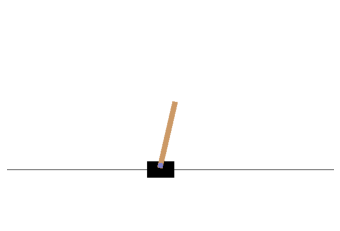

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

eval_eps = 5
ep_rewards = []
obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
while eval_eps > 0:
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
        aciton = policy.get_action(obs, deterministic=True)
        obs, reward, done, _ = env.step(action)
        ep_reward += reward
        # Render
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
    ep_rewards.append(ep_reward)
    eval_eps -= 1

print("Average Eval Reward", sum(ep_rewards) / len(ep_rewards))
env.close()
del env
del img
print("Episodes:", num_ep)

# 2. DDPG
We previously implemented REINFORCE, the basic policy gradient method. Now we'll get fancier and implement DDPG.

DDPG, or deep-deterministic policy gradients is an off policy Q-learning method for continuous action space environments. The paper can be found here: https://arxiv.org/abs/1509.02971. 

Here's a good summary of DDPG: https://spinningup.openai.com/en/latest/algorithms/ddpg.html


DDPG has the following basic ingredients:
1. A Q function that predicts the reward of different actions. Input = action + observation
2. A target Q function that is the EMA of the regular Q function for regression targets
3. A policy network that tries to learn to propose actions that maximize the Q function. As we are in continuous space, we can't simply take the argmax of the Q values.

The code will be slightly re-factored in comparison to last time. We'll be using the pendulum enviornment because it is continuous instead of discrete.

In [ ]:
# Import the required modules
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import gym

## a) Actor-Critic Networks
The first step is to implement the actor and critic models. For convenience I have provided a `space_size` function that will tell you the size of a gym space.

In [ ]:
def space_size(space):
    if isinstance(space, gym.spaces.Box):
        assert len(space.shape) == 1
        return space.shape[0]
    elif isinstance(space, gym.spaces.Dict):
        total = 0
        for k, v in space.spaces.items():
            assert len(space.spaces[k].shape) == 1
            total += space.spaces[k].shape[0]
        return total
    else:
        raise ValueError("Incorrectly formatted observation space")

class MLP(nn.Module):

    def __init__(self, in_dim, out_dim, layers=[128, 128], act='ReLU'):
        super().__init__()
        last_dim = in_dim
        model = []
        act = vars(nn)[act]
        for layer in layers:
            model.append(nn.Linear(last_dim, layer))
            last_dim = layer
            model.append(act())
        model.append(nn.Linear(last_dim, out_dim))
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Actor(nn.Module):

    def __init__(self, observation_space, action_space, layers=[128, 128], act='Tanh'):
        super().__init__()
        self.mlp = MLP(space_size(observation_space), space_size(action_space), layers=layers, act=act)
        self.action_bias = (action_space.high + action_space.low) / 2
        self.action_scale = (action_space.high - action_space.low) / 2 # Divide by 2 because want interval to be width 2 (-1 to 1)

    def forward(self, state):
        x = self.mlp(state)
        x = F.tanh(x)
        # appropriatly scale actions to action_space
        x = self.action_scale * x + self.action_bias
        return x

class Critic(nn.Module):

    def __init__(self, observation_space, action_space, layers=[128, 128], act='Tanh'):
        super().__init__()
        self.mlp = MLP(space_size(observation_space) + space_size(action_space), 1, layers=layers, act=act)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=-1)
        x = self.mlp(x)
        return x.squeeze(-1)

## b) Replay Buffer
In off-policy RL, we can re-use all our existing experience. We use a replay buffer to do this.

A replay buffer is essentially a LIFO queue for a fixed amount of data. As soon as the buffer is full, we eject the least recent sample to make room for a new one.



In [ ]:
from typing import NamedTuple
import random
import copy


class Batch(NamedTuple):
    obs: torch.Tensor
    ac: torch.Tensor
    next_obs: torch.Tensor
    done: torch.Tensor
    rew: torch.Tensor

class ReplayBuffer(object):
    
    def __init__(self, observation_space, action_space, size):
        self.obs = np.zeros((size, space_size(observation_space)), dtype=np.float32)
        self.next_obs = np.zeros((size, space_size(observation_space)), dtype=np.float32)
        self.ac = np.zeros((size, space_size(action_space)), dtype=np.float32)
        self.rew = np.zeros(size, dtype=np.float32)
        self.done = np.zeros(size, dtype=np.float32)
        self.idx = 0
        self.size = 0

    def add(self, obs, ac, next_obs, rew, done):
        self.obs[self.idx] = obs
        self.ac[self.idx] = ac
        self.next_obs[self.idx] = next_obs
        self.rew[self.idx] = rew
        self.done[self.idx] = done
        self.idx += 1
        if self.idx >= len(self.obs):
            self.idx = 0
        self.size = min(self.size + 1, len(self.obs))
            
    def sample(self, batch_size):
        # get random permutation
        idxs = np.random.randint(0, self.size, size=batch_size)
        return Batch(*map(torch.tensor, (self.obs[idxs], self.ac[idxs], self.next_obs[idxs], self.done[idxs], self.rew[idxs])))

## c) Training Class
For better coding practice, we'll define the algorithm in a class this time.

You will need to be sure to do the following:
1. Create the replay buffer
2. Create the actor and critic
3. Create the target actor and target critic as EMA of the actor and critic.
4. Compute the Q loss and the actor loss appropriately
5. Add noise to the actions. The amount of noise you add is a hyper-parameter that could need to be tuned.
6. Define the training loop.
7. For extra speed make sure you disable- and re-enable gradients on models you aren't updating!

In [ ]:
class DDPG(object):

    def __init__(self, env, update_freq=4, lr=0.001, batch_size=128, buffer_size=500000, layers=[128, 128], act='Tanh'):
        # Params
        self.gamma = 0.98
        self.tau = 0.995
        self.env = env
        self.update_freq = update_freq
        self.batch_size = batch_size

        # Setup
        self.replay_buffer = ReplayBuffer(env, env.observation_space, env.action_space, buffer_size)
        self.actor = Actor(env.observation_space, env.action_space, layers=layers, act=act)
        self.target_actor = Actor(env.observation_space, env.action_space, layers=layers, act=act)
        self.critic = Critic(env.observation_space, env.action_space, layers=layers, act=act)
        self.target_critic = Critic(env.observation_space, env.action_space, layers=layers, act=act)
        # Copy the critic weights to the target
        self.target_actor.load_state_dict(self.actor.state_dict())
        for p in self.target_actor.parameters():
            p.requires_grad = False
        self.target_critic.load_state_dict(self.critic.state_dict())
        for p in self.target_critic.parameters():
            p.requires_grad = False

        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=lr)
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=lr)

    def update_critic(self, batch):
        self.critic_opt.zero_grad()
        with torch.no_grad():
            target = batch.rew + self.gamma*(1 - batch.done)*self.target_critic(batch.next_obs, self.target_actor(batch.next_obs))
        pred = self.critic(batch.obs, batch.ac)
        assert target.shape == pred.shape
        loss = F.mse_loss(pred, target)
        loss.backward()
        self.critic_opt.step()
        return loss.item()

    def update_actor(self, batch):
        # Don't compute gradients for Q
        for p in self.critic.parameters():
            p.requires_grad = False
        self.actor_opt.zero_grad()
        pred_ac = self.actor(batch.obs)
        pred_q = self.critic(batch.obs, pred_ac)
        loss = -1 * torch.mean(pred_q)
        loss.backward()
        self.actor_opt.step()
        # Re-enable grads
        for p in self.critic.parameters():
            p.requires_grad = True
        return loss.item()

    def learn(self, timesteps, log_freq=100):
        num_updates = 0
        ep_rewards = []
        ep_lengths = []
        rew_list = []
        obs = env.reset()
        
        for i in range(timesteps):

            if i % self.update_freq == 0 and len(ep_rewards) > 10:
                batch = self.replay_buffer.sample(self.batch_size)
                critic_loss = self.update_critic(batch)
                actor_loss = self.update_actor(batch)

                # Polyak average the target network
                with torch.no_grad():
                    for p, target_p in zip(self.critic.parameters(), self.target_critic.parameters()):
                        target_p.data.mul_(self.tau)
                        target_p.data.add_((1 - self.tau) * p.data)
                    for p, target_p in zip(self.actor.parameters(), self.target_actor.parameters()):
                        target_p.data.mul_(self.tau)
                        target_p.data.add_((1 - self.tau) * p.data)

                num_updates += 1
                if num_updates % log_freq == 0:
                    print("===========================")
                    print("Timesteps:", i, "Updates:", num_updates)
                    print("Actor Loss", actor_loss)
                    print("Critic Loss", critic_loss)
                    print("10 Ep Avg Rew", np.mean(ep_rewards[-10:]))

            # Take a step in the environment
            if len(ep_rewards) > 10:
                with torch.no_grad():
                    obs = torch.tensor(obs).unsqueeze(0).float()
                    ac = self.actor(obs)[0].cpu().numpy()
                    ac += 0.05 * np.random.randn(self.env.action_space.shape[0]) # Add action noise.
                    ac = np.clip(ac, self.env.action_space.low , self.env.action_space.high)
            else:
                ac = self.env.action_space.sample()

            next_obs, rew, done, _ = env.step(ac)
            self.replay_buffer.add(obs, ac, next_obs, rew, done)
            obs = next_obs
            rew_list.append(rew)

            if done:
                ep_rewards.append(sum(rew_list))
                ep_lengths.append(len(rew_list))
                rew_list = []
                obs = env.reset()


## d) Testing!
We'll test on the pendulum environment.
The code for this should be super simple!
Try to get the best final reward possible. Warning: this could take upwards of 30 minutes to run. However, you should see it improve pretty rapidly. Unlike REINFORCE, DDPG is a much more stable algorithm :)

Within 30000 timesteps and 7000 updates I was able to get to a reward of around -300


In [ ]:
env = gym.make("Pendulum-v0")
alg = DDPG(env, batch_size=128, update_freq=4, lr=0.001)
alg.learn(500000, log_freq=1000)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timesteps: 6196 Updates: 1000
Actor Loss 35.77605438232422
Critic Loss 0.7138609886169434
10 Ep Avg Rew -1301.0945506449948
Timesteps: 10196 Updates: 2000
Actor Loss 56.18666458129883
Critic Loss 0.7831288576126099
10 Ep Avg Rew -1092.9253883212305
Timesteps: 14196 Updates: 3000
Actor Loss 72.72393798828125
Critic Loss 50.39295196533203
10 Ep Avg Rew -752.8046634416849
Timesteps: 18196 Updates: 4000
Actor Loss 72.17211151123047
Critic Loss 2.6399707794189453
10 Ep Avg Rew -444.9932328596261
Timesteps: 22196 Updates: 5000
Actor Loss 73.7801742553711
Critic Loss 160.18409729003906
10 Ep Avg Rew -322.5906975859953
Timesteps: 26196 Updates: 6000
Actor Loss 69.15165710449219
Critic Loss 87.8898696899414
10 Ep Avg Rew -320.9658277644686
Timesteps: 30196 Updates: 7000
Actor Loss 71.68630981445312
Critic Loss 4.187958717346191
10 Ep Avg Rew -230.84251398424686
Timesteps: 34196 Updates: 8000
Actor Loss 72.52184295654297
Critic Loss 86.21086120605469
10 Ep Avg Rew -378.04171344369047
Timesteps: 